# regression-02

## What's new:

1- remove unnecessary rows for training model.


In [3]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras import callbacks

In [4]:
# 1- Load and Scaling Features

df = pd.read_csv('XAGUSD-197001010000--H1-rates.csv', sep='\t')
# Rename columns for easier access
df.rename(columns={
    '<DATE>': 'DATE',
    '<TIME>': 'TIME',
    '<OPEN>': 'OPEN',
    '<HIGH>': 'HIGH',
    '<LOW>': 'LOW',
    '<CLOSE>': 'CLOSE',
    '<TICKVOL>': 'TICKVOL',
    '<VOL>': 'VOL',
    '<SPREAD>': 'SPREAD'
}, inplace=True)

df['DATETIME'] = pd.to_datetime(df['DATE'] + ' ' + df['TIME'])


# Drop rows with missing values
df.dropna(inplace=True)

# Sort data chronologically by DATETIME
df.sort_values(by='DATETIME', inplace=True)

# Reset index to ensure clean row order
df.reset_index(drop=True, inplace=True)


In [5]:
# Specify how many rows to remove for model
nn = 1000   # Delete the first nn rows that do not follow the one-hour timeframe.
mm = 500   # Remove mm last row that the model should not see.

# Delete first nn and last mm rows
df_model = df.iloc[nn:len(df)-mm].reset_index(drop=True)

In [6]:
# Select features to scale
features = ['OPEN', 'HIGH', 'LOW', 'CLOSE', 'TICKVOL']

# Apply MinMaxScaler
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df_model[features])

close_scaler = MinMaxScaler()
scaled_close = close_scaler.fit_transform(df_model[['CLOSE']])

In [7]:
# --- Parameters ---

WINDOW_SIZE = 60
FORECAST_HORIZON = 10

In [8]:
# Prepare sequences
def create_sequences(features, target, window, horizon):
    X, y = [], []
    for i in range(window, len(features) - horizon):
        X.append(features[i - window:i])
        y.append(target[i:i + horizon])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled, scaled_close, WINDOW_SIZE, FORECAST_HORIZON)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Build basic LSTM model
model = Sequential([
    LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(FORECAST_HORIZON)
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train
mc = callbacks.ModelCheckpoint(filepath='mcp_saved_model.keras', monitor='val_loss', save_best_only=True)
es = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    epochs=50,
    verbose=1,
    callbacks=[mc, es],
    validation_split=0.2,
)

/home/saeed/repositories/machine-learning/forex-prediction/envs/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - loss: 0.0010 - mae: 0.0096 - val_loss: 6.2039e-05 - val_mae: 0.0057
Epoch 2/50
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 5.5229e-05 - mae: 0.0047 - val_loss: 7.2926e-05 - val_mae: 0.0063
Epoch 3/50
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 4.8281e-05 - mae: 0.0043 - val_loss: 4.2134e-05 - val_mae: 0.0043
Epoch 4/50
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 4.4908e-05 - mae: 0.0042 - val_loss: 5.6056e-05 - val_mae: 0.0055
Epoch 5/50
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 4.2684e-05 - mae: 0.0040 - val_loss: 3.7208e-05 - val_mae: 0.0039
Epoch 6/50
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 3.9856e-05 - mae: 0.0038 - val_loss: 3.8550e-05 - val_mae: 0.0040
Epoch 7/50
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 3.8588e-05 - mae: 0.0038 - val_loss: 3.9826e-05 - val_mae: 0.0043
Epoch 8/50
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - loss: 3.8162e-05 - mae: 0.0038 - val_loss: 4

In [9]:
# === Load and clean the last 60 rows from a separate CSV file for prediction ===
# --- Find the starting index ---

given_time = "2025.07.31 10:00:00"   # starting datetime

start_idx = df.index[df['DATETIME'] == pd.to_datetime(given_time)][0]

# --- 1. Extract next n candles ---
input_df = df.iloc[start_idx : start_idx + WINDOW_SIZE].copy()


input_scaled = scaler.transform(
    input_df[['OPEN', 'HIGH', 'LOW', 'CLOSE', 'TICKVOL']])
input_sequence = np.expand_dims(input_scaled, axis=0)  # shape: (1, 60, 5)

# === Predict the next 10 candles + Inverse scale ===
pred = model.predict(input_sequence)
prediction = close_scaler.inverse_transform(pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


# plot section

In [10]:
# --- 2. Extract last 4 candles from input_df ---
historical_df = input_df.tail(4).copy()

# --- 3. Extract next 10 candles immediately after input_df ---
actual_future_df = df.iloc[start_idx + WINDOW_SIZE - 1 : start_idx + WINDOW_SIZE + FORECAST_HORIZON].copy()

plot_title = 'Actual vs Predicted Forex Closing Prices'
output_plot_path = None  # e.g., 'output.png'

# LOAD DATA FROM PREDICTION

last_timestamp = input_df['DATETIME'].iloc[-1]
datetime_index = pd.date_range(start=last_timestamp + pd.Timedelta(hours=1), periods=len(prediction[0]), freq='h')

# Create DataFrame
predicted_df = pd.DataFrame({'DATETIME': datetime_index, 'CLOSE': prediction[0]})

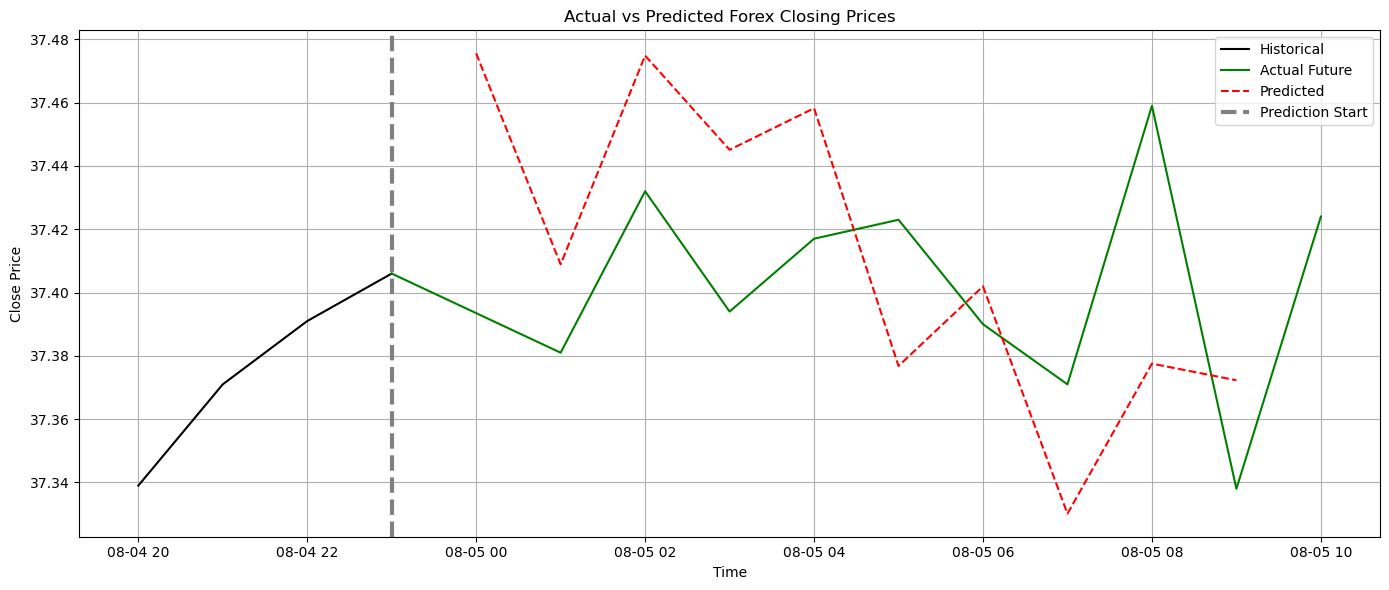

In [11]:
import sys
sys.path.insert(1, '../utils')
import forex_plot_utils_2

# PLOT
forex_plot_utils_2.plot_all_series(
    historical_df=historical_df,
    predicted_df=predicted_df,
    actual_future_df=actual_future_df,
    title=plot_title,
    output_path=output_plot_path
)

In [12]:
from datetime import datetime
import os
import pandas as pd
import matplotlib.pyplot as plt

# === Create timestamp and paths ===
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
model_filename = f'model_{timestamp}.keras'
model_path = os.path.join('saved_models', model_filename)

# Directory to hold logs and extras
log_dir = os.path.join('saved_models', f'model_{timestamp}_logs')
os.makedirs(log_dir, exist_ok=True)

# === Save model ===
model.save(model_path)

# === Save training history ===
history_df = pd.DataFrame(history.history)
history_df.to_csv(os.path.join(log_dir, 'training_history.csv'), index=False)

# === Save training loss plot ===
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(log_dir, 'training_loss.png'))
plt.close()

# === Save model summary and final performance ===
with open(os.path.join(log_dir, 'model_log.txt'), 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))
    final_train_loss = history.history['loss'][-1]
    final_test_loss, final_test_mae = model.evaluate(X_test, y_test, verbose=0)
    f.write(f'\nFinal Training Loss: {final_train_loss:.6f}\n')
    f.write(f'Final Test Loss: {final_test_loss:.6f}\n')
    f.write(f'Final Test MAE : {final_test_mae:.6f}\n')
